In [9]:
# Numerical
from jax.numpy import exp, sin, pi, mean, var    # Arithematic
from jax.numpy import arange, array, zeros # Array creation routines
from jax.lax import scan 
from jax import jit, jacrev, jacfwd

# Miscellaneous
from functools import partial 
from os import getcwd
from ticktack import load_presaved_model
from ticktack.fitting import SingleFitter

# ODEINTs
from ode import odeint as BS3
from jax.experimental.ode import odeint as DP5
from time import process_time

# Visualisation
from pandas import DataFrame
from plotnine import *
import matplotlib.pyplot as plt

In [10]:
UNIT_FACTOR = 14.003242 / 6.022 * 5.11 * 31536. / 1.e5
PRODUCTION_RATE = 1.76

In [11]:
def profile(func, *args, **kwargs) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.
    """
    time_sample = zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()             # Starting a timer 
        solution = func(*args, **kwargs)   # Running the model 
        map(array, solution) # Forcing vistation of the values (equivalent to block_until_ready)
        timer = process_time() - timer     # Stopping the timer

        time_sample = time_sample.at[i].set(timer)  # Storing the timer 

    return {
        "average": mean(time_sample), 
        "variance": var(time_sample),
        "solution": solution
        }

In [12]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    """
    A linear ode solver that is designed to be compatible with the `ticktack` architecture. 
    """
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None):
        """
        A utility function that is passed through scan(map) to produce the final result.
        """
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)
    step = jit(step)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values

In [13]:
def production(t, *args, steady_state=PRODUCTION_RATE):
    start, duration, phase, area = array(list(args)).reshape(-1)

    middle = start + duration / 2.
    height = area / duration
    gaussian = height * exp(- ((t - middle) / (duration / 2)) ** 16.)
    sinusoid = 0.18 * steady_state * sin(2 * pi / 11 * t + phase)
    production = gaussian + sinusoid + steady_state
    
    return UNIT_FACTOR * production

In [14]:
carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
carbon_box_model.compile()

In [15]:
burn_in_time_out = arange(-225, 775)
burn_in_oversample = 1000
parameters = (774.86, 0.25, 0.8, 6.44)
growth_season = array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [16]:
# Running the burn-in
_, y_initial = carbon_box_model.run(burn_in_time_out, burn_in_oversample, \
    production, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

In [17]:
time_out = arange(750, 800)

In [18]:
true_values, _ = carbon_box_model.run(time_out, burn_in_oversample, production,\
    y0=y_initial, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

true_values = list(true_values[:, 1]) # Selecting the troposphere
time_values = [round(750 + i / burn_in_oversample, 3) for i in range(burn_in_oversample * 51)]

true_values = dict(zip(time_values, true_values))

In [19]:
odeint = {"Linear": odeint_linear, "BS3": BS3, "DP5": DP5}

In [20]:
odeint_oversample_resids = {
    "Solver": [],
    "Oversample": [],
    "Time (s)": [],
    "Time Var (s)": [],
    "Accuracy": []
}

In [21]:
for solver in odeint:
    for oversample in range(10, 1000, 50):
        o_profile = profile(# Profiling the standard solver through the ticktack tools 
            carbon_box_model.run, time_out, oversample, production, \
            solver=odeint[solver], y0=y_initial, args=parameters, \
            steady_state_production=PRODUCTION_RATE * UNIT_FACTOR
        )

        # Calculating the residuals
        solution = o_profile["solution"][0][:, 1] # Selecting the troposphere values

        time_values = [round(750 + i / oversample, 3) for i in range(oversample * 51)]  # Generating the time values 
        local_true_value = [true_values[time_value] for time_value in time_values]  # Selecting the correct local values 

        residuals = solution - array(local_true_value)  # Calculating the residuals 
        accuracy = float(mean(residuals))   # Getting the accuracy

        # Removing values from memory that are no longer needed
        del solution
        del local_true_value
        del residuals
        del time_values

        # Added everything to the data frame
        odeint_oversample_resids["Solver"].append(solver)
        odeint_oversample_resids["Oversample"].append(oversample)
        odeint_oversample_resids["Time (s)"].append(float(o_profile["average"]))
        odeint_oversample_resids["Time Var (s)"].append(float(o_profile["variance"]))
        odeint_oversample_resids["Accuracy"].append(abs(accuracy))

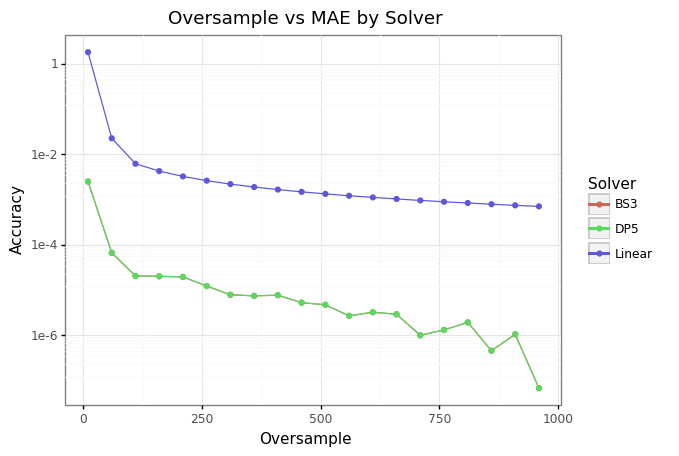

<ggplot: (8775905894081)>

In [22]:
odeint_oversample_resids = DataFrame(odeint_oversample_resids)
(ggplot(odeint_oversample_resids, 
    aes(
        x="Oversample", 
        y="Accuracy", 
        color="Solver"
    ))
    + theme_bw()
    + geom_line()
    + geom_point()
    + scale_y_log10()
    + ggtitle("Oversample vs MAE by Solver"))

In [23]:
odeint_oversample_resids["ymin"] = odeint_oversample_resids["Time (s)"] - \
     odeint_oversample_resids["Time Var (s)"]
odeint_oversample_resids["ymax"] = odeint_oversample_resids["Time (s)"] + \
     odeint_oversample_resids["Time Var (s)"]

/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/pandas-1.4.0rc0-py3.9-linux-x86_64.egg/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10


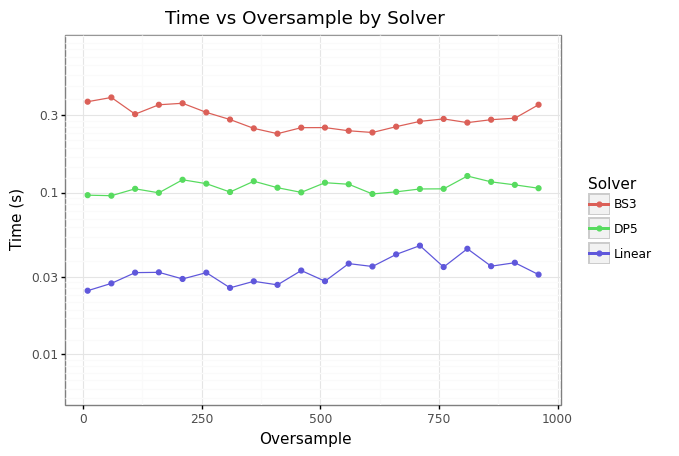

<ggplot: (8775855708588)>

In [24]:
(ggplot(odeint_oversample_resids, 
    aes(
        x="Oversample", 
        y="Time (s)",
        ymin="ymin",
        ymax="ymax",
        color="Solver"
    ))
    + theme_bw()
    + geom_line()
    + geom_point()
    # + geom_errorbar()
    + scale_y_log10()
    + ggtitle("Time vs Oversample by Solver"))

Experimental analysis follows

In [25]:
loss_function_object = SingleFitter(carbon_box_model, "Guttler14")
loss_function_object.load_data(f"{getcwd()}/datasets/775AD/NH/Miyake12_Cedar.csv")
loss_function_object.prepare_function(production)
loss = loss_function_object.log_likelihood

In [27]:
results = {
    "module": [],
    "time": [],
    "type": []
}

for solver in odeint:# Iterating through the namespaces of odeint function 
    r_profile = profile(
        carbon_box_model.run, time_out, oversample, production, \
        solver=odeint[solver], y0=y_initial, args=parameters, \
        steady_state_production=PRODUCTION_RATE * UNIT_FACTOR
    )
    results["module"].append(solver)
    results["time"].append(float(r_profile["average"]) * 1000)
    results["type"].append("odeint")

    # The gradients exist below 
    def gradient(p): 
        try:
            return jacfwd(loss)(p)         # Calculating the gradient 
        except:
            return jacrev(loss)(p)

    g_profile = profile(gradient, parameters)

    results["module"].append(solver)
    results["time"].append(float(g_profile["average"]) * 1000)
    results["type"].append("gradient")

    def hessians(p): 
        try:
            return jacfwd(jacfwd(loss))(params=p) # Calculating the hessian 
        except:
            return jacrev(jacrev(loss))(params=p)

    h_profile = profile(hessians, parameters)

    results["module"].append(solver)
    results["time"].append(float(h_profile["average"]) * 1000)
    results["type"].append("hessian")

IndexError: tuple index out of range

In [ ]:
results = DataFrame(results)  # Switching to a pandas data frame
(ggplot(results, aes(x="module", y="time", fill="type"))
    + geom_col(position="dodge")
    + geom_label(aes(label="round(time)"), position=position_dodge(width=0.9))
    + scale_y_log10()
    + theme_bw())